In [ ]:
!pip install fasttext scikit-learn

import numpy as np
import fasttext
import sklearn
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498210 sha256=2834b85b03781ef1cadbb72e5c5f06dea01b7cbb2f8890cd1f07768c3bb0642c
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


# Document classification using k-NN and Naive Bayes
Today, we will work with the [20 newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset from 1997. It contains relatively short articles (as well as some longer ones) from 20 different newsgroups (see below).

Our goal is to decide which group a given document comes from. To make the task more challenging, we will remove any superfluous metadata, and we'll judge each document purely by its content. Don't expect perfect accuracy.

In last week's lab, you were introduced to TF-IDF and sentence embedding using Word2Vec. We'll use these techniques as well but, this time we'll employ k-Nearest Neighbors and Naive Bayes classifiers.



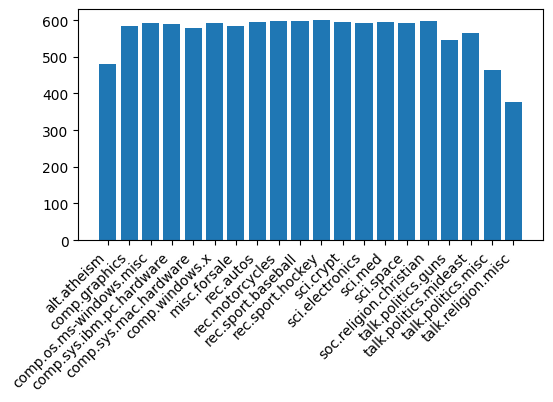

In [ ]:
# fetch dataset
from sklearn.datasets import fetch_20newsgroups
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(range(len(train.target_names)), np.bincount(train.target), align='center')
plt.xticks(range(len(train.target_names)), train.target_names, rotation=45, ha='right')
plt.show()

# 1) Vectorizing the documents
The sklearn implementations of both k-Nearest Neighbors and Naive Bayes classifiers take vectors of fixed length. So, we must first vectorize the documents.

Sklearn already implements [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which simply counts the occurrences of each word from a vocabulary, and [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which you should already be familiar with.

We'll also implement our own vectorizers.
First, implement `EmbeddingVectorizer` below, which will vectorize documents using a given Word2Vec embedding model.

Last week, you saw that ignoring certain "stopwords" often helps. Instead of ignoring them, we could lower their influence by weighting each word embedding by its inverse document frequency (IDF). Try implementing this in `IdfWeightedEmbeddingVectorizer`.

In [ ]:
import os

# download a pre-trained Word2Vec model
if os.path.exists('cc.en.300.bin'):
    print('FastText models already downloaded.')
else:
    ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    ! gunzip cc.en.300.bin.gz

embeddings = fasttext.load_model('cc.en.300.bin')

--2025-11-14 08:26:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.33, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   266MB/s    in 38s     

2025-11-14 08:27:25 (112 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
class EmbeddingVectorizer(TransformerMixin, BaseEstimator):
  def __init__(self, embedding):
    self.embedding: fasttext.FastText._FastText = embedding
    self.dim = embedding.get_dimension()
  def fit(self, X, y=None):
    return self
  def transform(self, X: list[str]) -> np.ndarray:
    # TODO: implement this method. It should:
    # 1. take a list of documents X
    # 2. use self.embedding to convert each document to a vector of fixed size
    # (for example by computing the mean of the word embeddings)
    # 3. return a numpy array
    #
    # hint: self.embedding should already have a method to get vector from a whole sentence
    # 2nd hint: that method does not like newlines, you can remove them with document.replace('\n', ' ')
    return np.asarray([
        self.embedding.get_sentence_vector(document.replace('\n', ' '))
        for document in X
    ])
    #return np.asarray([
    #    np.mean([
    #        self.embedding.get_word_vector(word)
    #        for word in document.split()
    #    ], axis=0)
    #    if len(document.split()) > 0 else np.zeros(self.dim)
    #    for document in X
    #])

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
class IdfWeightedEmbeddingVectorizer(TransformerMixin, BaseEstimator):
  def __init__(self, embedding):
    self.embedding: fasttext.FastText._FastText = embedding
    self.idf_weights = None
    self.dim = embedding.get_dimension()

  def fit(self, X, y=None):
    tfidf = TfidfVectorizer(analyzer=lambda x: x)
    tfidf.fit(X)
    # if a word was never seen - it must be at least as infrequent
    # as any of the known words - so the default idf is the max of
    # known idf's
    max_idf = max(tfidf.idf_)
    self.idf_weights = defaultdict(
        lambda: max_idf,
        [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return self

  def transform(self, X: list[str]) -> np.ndarray:
    # TODO: implement
    # Same as before but this time compute a weighted mean of the word embeddings
    # using the computed IDF weights.
    # Hint: some documents have no words, make sure to return a vector of zeroes of the correct dimension for those
    # Hint 2: you can vectorize a word with self.embedding.get_word_vector(w) and get its weight with self.idf_weights[w]
    return np.asarray([
      np.sum([
          self.embedding.get_word_vector(word) * self.idf_weights[word]
          for word in document.split()
      ], axis=0) / np.sum([self.idf_weights[word] for word in document.split()])
      if len(document.split()) > 0 else np.zeros(self.dim)
      for document in X
    ])


# 1.5) Simple document lookup engine
Lets use our vectorizers in a very simplistic document lookup engine.
The lookup engine works by comparing the vectors of stored documents with a vector computed from a given query. It then shows the documents whose vectors are closest to the query. Try it out!

What metric makes sense for finding the closest document vectors?

Why doesn't the euclidean metric work well with the TF-IDF vectors?

In [ ]:
from sklearn.metrics import pairwise_distances

class RelevantDocumentFinder:
  def __init__(self, documents: list[str], labels: list[str], vectorizer):
    self.documents = documents
    self.labels = labels
    self.vectorizer = vectorizer
    self.vectors = self.vectorizer.fit_transform(documents)
    pass
  def query(self, query: str, num_nearest: int = 5, metric: str = 'euclidean'):
    query_vec = self.vectorizer.transform([query])
    distances = pairwise_distances(self.vectors, query_vec.reshape(1, -1), metric=metric)
    nearest = np.argsort(distances, axis=0)[:num_nearest].flatten()
    for idx in nearest:
      print(f"Distance: {distances[idx][0]:.2f}")
      print(f"Group: {train.target_names[self.labels[idx]]}")
      print(f"Document:\n{self.documents[idx]}")
      print("-----------------------------------------------")

finder = RelevantDocumentFinder(train.data, train.target, EmbeddingVectorizer(embedding=embeddings))
#finder = RelevantDocumentFinder(train.data, train.target, IdfWeightedEmbeddingVectorizer(embedding=embeddings))
#finder = RelevantDocumentFinder(train.data, train.target, TfidfVectorizer())

query = "The pope and the church."
finder.query(query, metric='cosine')

Distance: 0.22
Group: alt.atheism
Document:


As to what that headpiece is....

(by chort@crl.nmsu.edu)

SOURCE: AP NEWSWIRE

The Vatican, Home Of Genetic Misfits?

Michael  A. Gillow, noted geneticist, has revealed  some unusual  data
after working undercover in  the Vatican for the past 18 years.   "The
Popehat(tm) is actually an advanced bone spur.", reveals Gillow in his
groundshaking report. Gillow, who had  secretly  studied the innermost
workings of the Vatican since returning from Vietnam in a wheel chair,
first approached the scientific community with his  theory in the late
1950's.

"The  whole hat  thing, that was just a cover  up. The  Vatican didn't
want the Catholic Community(tm) to realize  their  leader  was hefting
nearly  8 kilograms of extraneous  bone  tissue on    the  top of  his
skull.", notes Gillow in his report. "There are whole  laboratories in
the  Vatican  that experiment with tissue  transplants and bone marrow
experiments.  What started as a genetic fluke

# 2. Document classification with k-Nearest Neighbors
In `RelevantDocumentFinder`, we looked at which document vectors are close to the vector of our query. We could also use the labels of those nearby documents to decide which newsgroup our query corresponds to.

Treating a previously unseen document as a query, finding its `k` nearest neighboring documents, and taking the most frequent label is precisely how the [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) works.

Try it together with different document vectorizers. Which one works best for this dataset? Which metric works best? Also try neighbor weighting.

                          precision    recall  f1-score   support

             alt.atheism       0.19      0.31      0.24       319
           comp.graphics       0.29      0.43      0.35       389
 comp.os.ms-windows.misc       0.26      0.30      0.28       394
comp.sys.ibm.pc.hardware       0.24      0.42      0.30       392
   comp.sys.mac.hardware       0.29      0.26      0.27       385
          comp.windows.x       0.52      0.43      0.47       395
            misc.forsale       0.72      0.56      0.63       390
               rec.autos       0.50      0.48      0.49       396
         rec.motorcycles       0.53      0.39      0.45       398
      rec.sport.baseball       0.70      0.52      0.60       397
        rec.sport.hockey       0.72      0.69      0.70       399
               sci.crypt       0.41      0.55      0.47       396
         sci.electronics       0.48      0.24      0.32       393
                 sci.med       0.76      0.55      0.64       396
         

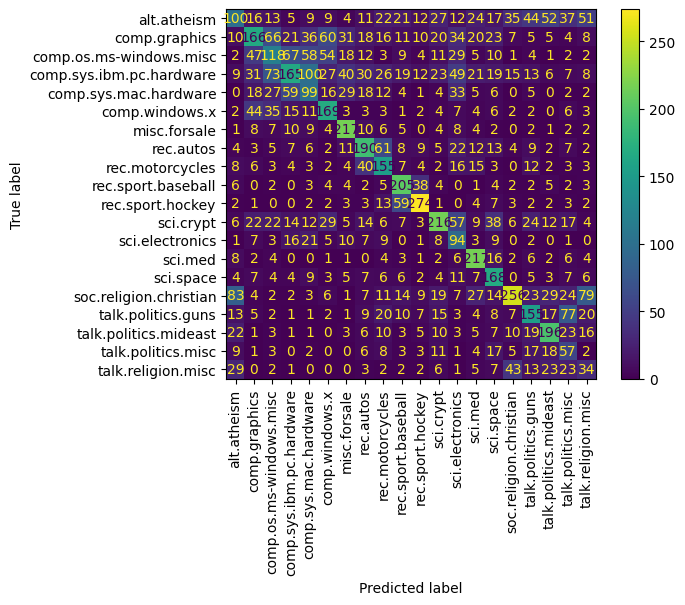

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a k-nearest neighbors classifier
# First vectorize the documents. Try different vectorizers:
#   CountVectorizer, TfidfVectorizer, EmbeddingVectorizer, IdfWeightedEmbeddingVectorizer
# Try different parameters for KNeighborsClassifier, which metric works best?
#
# Which groups are easy to confuse?

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', EmbeddingVectorizer(embedding=embeddings)),
    ('classifier', KNeighborsClassifier(n_neighbors=5, metric='cosine'))
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.20      0.33      0.25       319
           comp.graphics       0.21      0.40      0.27       389
 comp.os.ms-windows.misc       0.27      0.29      0.28       394
comp.sys.ibm.pc.hardware       0.33      0.42      0.37       392
   comp.sys.mac.hardware       0.28      0.20      0.23       385
          comp.windows.x       0.48      0.41      0.44       395
            misc.forsale       0.65      0.57      0.61       390
               rec.autos       0.48      0.46      0.47       396
         rec.motorcycles       0.50      0.38      0.44       398
      rec.sport.baseball       0.67      0.48      0.56       397
        rec.sport.hockey       0.68      0.67      0.68       399
               sci.crypt       0.37      0.52      0.43       396
         sci.electronics       0.47      0.25      0.33       393
                 sci.med       0.73      0.54      0.62       396
         

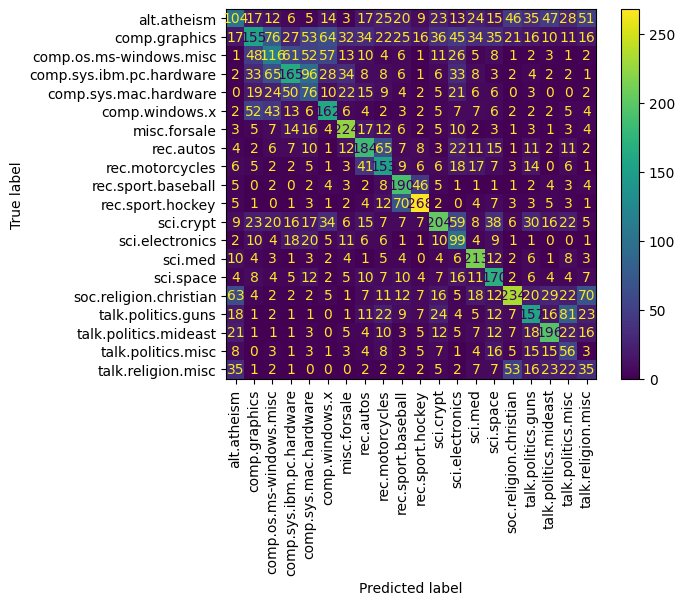

In [ ]:
# Try different vectorizers and parameters,from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a k-nearest neighbors classifier
# First vectorize the documents. Try different vectorizers:
#   CountVectorizer, TfidfVectorizer, EmbeddingVectorizer, IdfWeightedEmbeddingVectorizer
# Try different parameters for KNeighborsClassifier, which metric works best?
#
# Which groups are easy to confuse?

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', EmbeddingVectorizer(embedding=embeddings)),
    ('classifier', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.15      0.33      0.20       319
           comp.graphics       0.21      0.30      0.24       389
 comp.os.ms-windows.misc       0.21      0.26      0.23       394
comp.sys.ibm.pc.hardware       0.21      0.35      0.26       392
   comp.sys.mac.hardware       0.25      0.21      0.23       385
          comp.windows.x       0.39      0.35      0.37       395
            misc.forsale       0.63      0.45      0.53       390
               rec.autos       0.46      0.40      0.43       396
         rec.motorcycles       0.41      0.29      0.34       398
      rec.sport.baseball       0.64      0.40      0.49       397
        rec.sport.hockey       0.64      0.56      0.60       399
               sci.crypt       0.28      0.40      0.33       396
         sci.electronics       0.40      0.19      0.26       393
                 sci.med       0.48      0.38      0.42       396
         

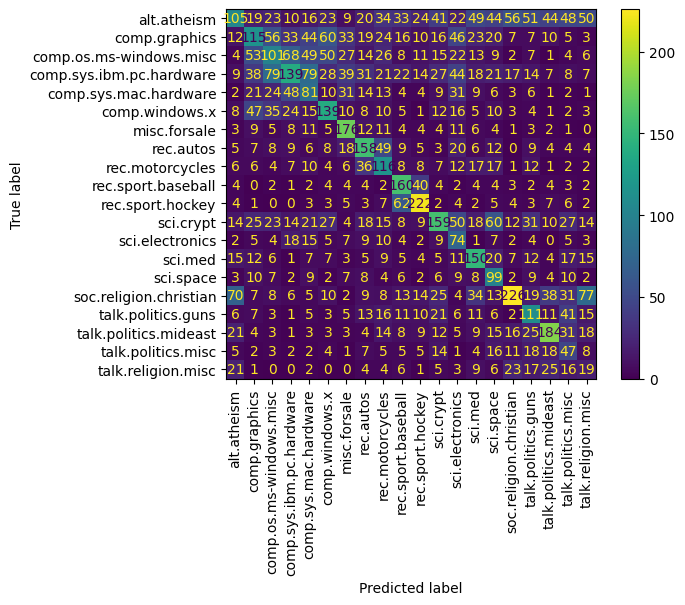

In [ ]:
# Try different vectorizers and parameters,from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a k-nearest neighbors classifier
# First vectorize the documents. Try different vectorizers:
#   CountVectorizer, TfidfVectorizer, EmbeddingVectorizer, IdfWeightedEmbeddingVectorizer
# Try different parameters for KNeighborsClassifier, which metric works best?
#
# Which groups are easy to confuse?

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', IdfWeightedEmbeddingVectorizer(embedding=embeddings)),
    ('classifier', KNeighborsClassifier(n_neighbors=5, metric='cosine'))
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.06      0.18      0.09       319
           comp.graphics       0.07      0.18      0.10       389
 comp.os.ms-windows.misc       0.06      0.18      0.09       394
comp.sys.ibm.pc.hardware       0.12      0.14      0.13       392
   comp.sys.mac.hardware       0.05      0.08      0.06       385
          comp.windows.x       0.23      0.04      0.06       395
            misc.forsale       0.19      0.11      0.14       390
               rec.autos       0.07      0.18      0.10       396
         rec.motorcycles       0.10      0.06      0.07       398
      rec.sport.baseball       0.07      0.08      0.07       397
        rec.sport.hockey       0.15      0.08      0.10       399
               sci.crypt       0.14      0.05      0.07       396
         sci.electronics       0.08      0.03      0.04       393
                 sci.med       0.09      0.03      0.05       396
         

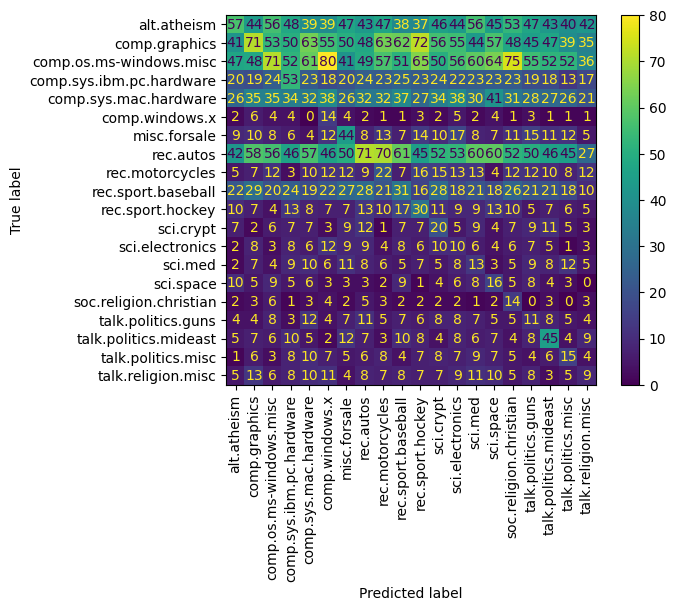

In [ ]:
# Try different vectorizers and parameters,from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a k-nearest neighbors classifier
# First vectorize the documents. Try different vectorizers:
#   CountVectorizer, TfidfVectorizer, EmbeddingVectorizer, IdfWeightedEmbeddingVectorizer
# Try different parameters for KNeighborsClassifier, which metric works best?
#
# Which groups are easy to confuse?

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.22      0.52      0.31       319
           comp.graphics       0.53      0.59      0.56       389
 comp.os.ms-windows.misc       0.48      0.54      0.51       394
comp.sys.ibm.pc.hardware       0.34      0.59      0.43       392
   comp.sys.mac.hardware       0.53      0.46      0.49       385
          comp.windows.x       0.73      0.62      0.67       395
            misc.forsale       0.71      0.46      0.56       390
               rec.autos       0.63      0.52      0.57       396
         rec.motorcycles       0.71      0.46      0.55       398
      rec.sport.baseball       0.80      0.55      0.65       397
        rec.sport.hockey       0.81      0.72      0.76       399
               sci.crypt       0.58      0.60      0.59       396
         sci.electronics       0.56      0.27      0.36       393
                 sci.med       0.77      0.42      0.54       396
         

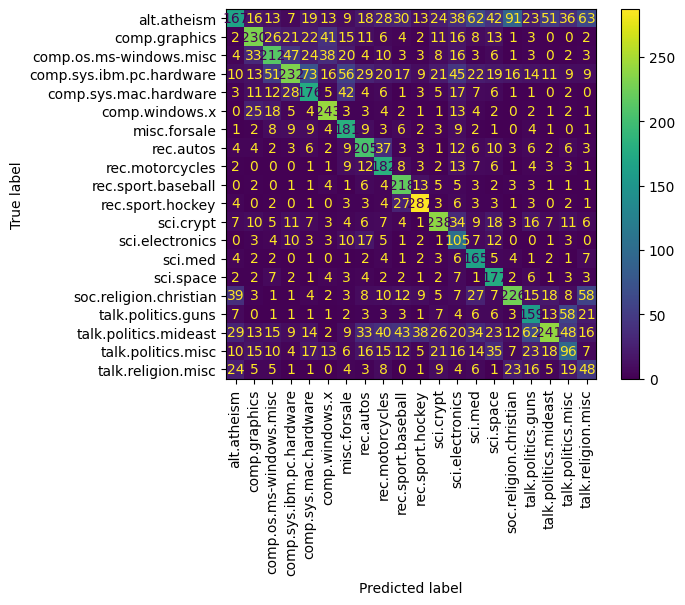

In [ ]:
# Try different vectorizers and parameters,from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a k-nearest neighbors classifier
# First vectorize the documents. Try different vectorizers:
#   CountVectorizer, TfidfVectorizer, EmbeddingVectorizer, IdfWeightedEmbeddingVectorizer
# Try different parameters for KNeighborsClassifier, which metric works best?
#
# Which groups are easy to confuse?

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier(n_neighbors=5, metric='cosine'))
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.35      0.46      0.40       319
           comp.graphics       0.65      0.53      0.58       389
 comp.os.ms-windows.misc       0.57      0.51      0.54       394
comp.sys.ibm.pc.hardware       0.37      0.63      0.47       392
   comp.sys.mac.hardware       0.61      0.47      0.53       385
          comp.windows.x       0.72      0.67      0.69       395
            misc.forsale       0.74      0.52      0.61       390
               rec.autos       0.67      0.50      0.57       396
         rec.motorcycles       0.73      0.48      0.58       398
      rec.sport.baseball       0.82      0.56      0.66       397
        rec.sport.hockey       0.82      0.70      0.75       399
               sci.crypt       0.55      0.63      0.59       396
         sci.electronics       0.56      0.29      0.38       393
                 sci.med       0.76      0.42      0.55       396
         

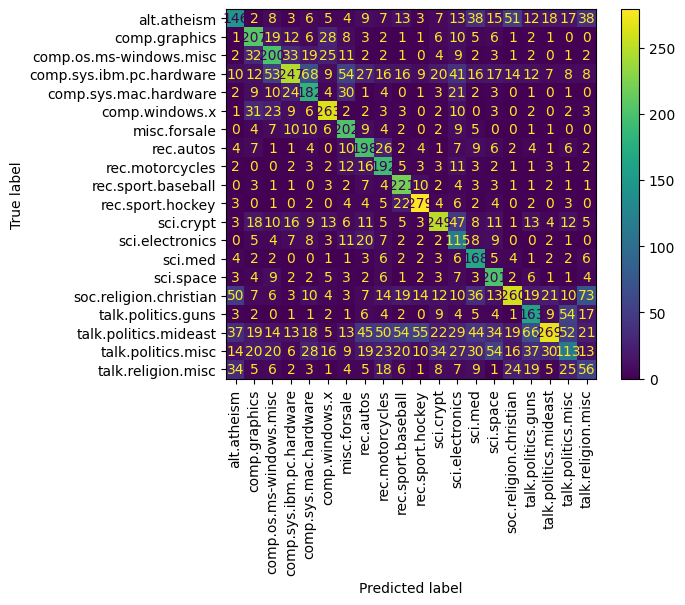

In [ ]:
# Try different vectorizers and parameters,from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Build a k-nearest neighbors classifier
# First vectorize the documents. Try different vectorizers:
#   CountVectorizer, TfidfVectorizer, EmbeddingVectorizer, IdfWeightedEmbeddingVectorizer
# Try different parameters for KNeighborsClassifier, which metric works best?
#
# Which groups are easy to confuse?

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance'))
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

# 3. Document classification with Naive Bayes

Recall that Naive Bayes uses the Bayes theorem to model the conditional distribution of labels given the features of a sample:
$$P(y | x_1, ..., x_d) = \frac{P(y)P(x_1, ..., x_d | y)}{P(x_1, ..., x_d)}$$

The denominator $P(x_1, ..., x_d)$ is just a constant given by our training data.

The "Naive" in Naive Bayes means that we naively assume the individual features to be (conditionally) pair-wise independent:
$$P(x_1, ..., x_d | y) \approx P(x_1|y)P(x_2|y)\cdots P(x_d|y)$$

Training an NB classifier involves estimating the probabilities $P(y)$ and $P(x_i|y)$ from the training data.

Classification is then done by simply choosing a label $\hat{y}$ that maximizes:
$$\hat{y} = \text{argmax}_y P(y)P(x_1|y)P(x_2|y)\cdots P(x_d|y)$$
for a given sample $x = (x_1, x_2, ..., x_d)$.

# Choosing features and modelling their distributions
$P(y)$ is simple to estimate from the proportion of each label in our training data. However, what features $x_i$ do we choose from our documents? How do we model their distributions $P(x_i|y)$? We have several options, try some of them:

### 1. Simplest: Bernoulli Naive Bayes
The simplest approach is to select a set of words (or the entire vocabulary) and for each word ask: "Is this word present in the document?" Representing the answer as 0/1, we obtain [Bernoulli distributed](https://en.wikipedia.org/wiki/Bernoulli_distribution) features.

With these features, we can train a [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html).
Hint: The `CountVectorizer` from `sklearn.feature_extraction.text` can be used to get such features. (BernoulliNB simply checks if a feature is nonzero and treats it as binary)

### 2. Better: Multinomial Naive Bayes
Instead of a binary flag, we can model the word counts from `CountVectorizer` using the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) with [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). While the distribution is defined for discrete values, the TF-IDF vectors can also be used with `MultinomialNB`. Which feature vectors perform better?

### 3. Another possible option: Gaussian Naive Bayes
The [`GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) assumes the features to be distributed by the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution). This means that it works with any real-valued features. We can therefore use it with word counts, TF-IDF vectors, as well as word embeddings.
(However, the implementation does not like sparse representations.)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

             alt.atheism       1.00      0.01      0.02       319
           comp.graphics       0.60      0.47      0.52       389
 comp.os.ms-windows.misc       0.33      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.45      0.71      0.55       392
   comp.sys.mac.hardware       0.46      0.69      0.55       385
          comp.windows.x       0.83      0.39      0.54       395
            misc.forsale       0.75      0.74      0.75       390
               rec.autos       0.41      0.68      0.51       396
         rec.motorcycles       0.17      0.94      0.28       398
      rec.sport.baseball       0.64      0.80      0.71       397
        rec.sport.hockey       0.99      0.51      0.67       399
               sci.crypt       0.67      0.37      0.47       396
         sci.electronics       0.55      0.53      0.54       393
                 sci.med       0.90      0.35      0.50       396
         

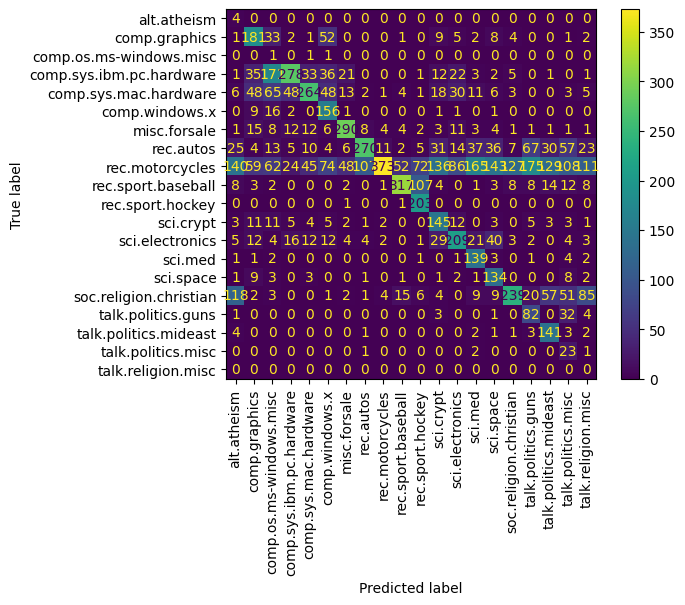

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', BernoulliNB()),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.65      0.15      0.25       319
           comp.graphics       0.63      0.60      0.62       389
 comp.os.ms-windows.misc       0.33      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.54      0.66      0.60       392
   comp.sys.mac.hardware       0.82      0.42      0.55       385
          comp.windows.x       0.53      0.81      0.64       395
            misc.forsale       0.88      0.55      0.68       390
               rec.autos       0.85      0.54      0.66       396
         rec.motorcycles       0.95      0.40      0.57       398
      rec.sport.baseball       0.97      0.56      0.71       397
        rec.sport.hockey       0.57      0.78      0.66       399
               sci.crypt       0.40      0.79      0.53       396
         sci.electronics       0.70      0.38      0.49       393
                 sci.med       0.82      0.67      0.74       396
         

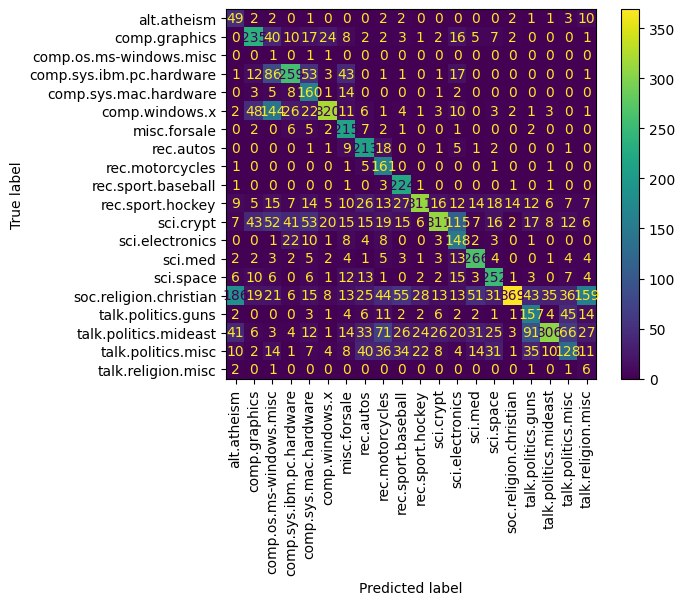

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB()),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.81      0.07      0.13       319
           comp.graphics       0.72      0.62      0.67       389
 comp.os.ms-windows.misc       0.70      0.50      0.59       394
comp.sys.ibm.pc.hardware       0.55      0.75      0.64       392
   comp.sys.mac.hardware       0.81      0.61      0.69       385
          comp.windows.x       0.83      0.74      0.78       395
            misc.forsale       0.86      0.69      0.77       390
               rec.autos       0.82      0.68      0.74       396
         rec.motorcycles       0.89      0.63      0.73       398
      rec.sport.baseball       0.95      0.69      0.80       397
        rec.sport.hockey       0.59      0.90      0.71       399
               sci.crypt       0.47      0.80      0.59       396
         sci.electronics       0.77      0.43      0.55       393
                 sci.med       0.86      0.63      0.73       396
         

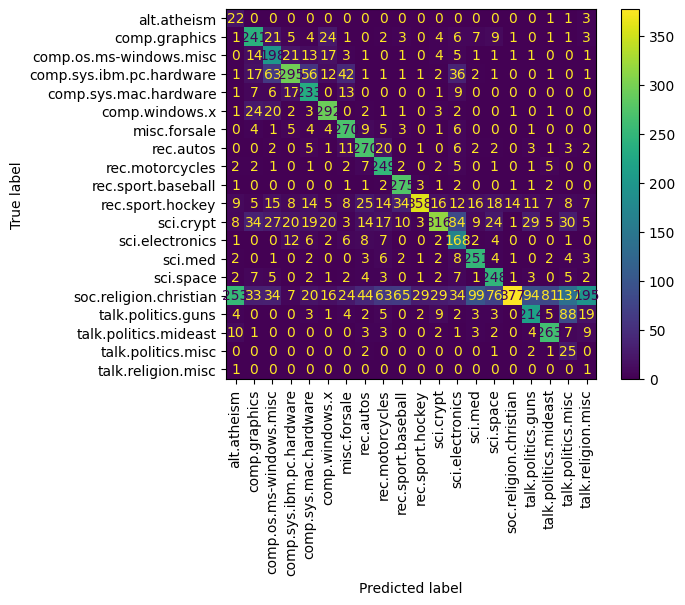

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.57      0.18      0.28       319
           comp.graphics       0.59      0.66      0.62       389
 comp.os.ms-windows.misc       0.63      0.56      0.60       394
comp.sys.ibm.pc.hardware       0.57      0.68      0.62       392
   comp.sys.mac.hardware       0.70      0.58      0.63       385
          comp.windows.x       0.77      0.72      0.75       395
            misc.forsale       0.81      0.75      0.78       390
               rec.autos       0.70      0.68      0.69       396
         rec.motorcycles       0.76      0.70      0.73       398
      rec.sport.baseball       0.81      0.75      0.78       397
        rec.sport.hockey       0.57      0.86      0.68       399
               sci.crypt       0.69      0.70      0.69       396
         sci.electronics       0.60      0.47      0.53       393
                 sci.med       0.73      0.70      0.71       396
         

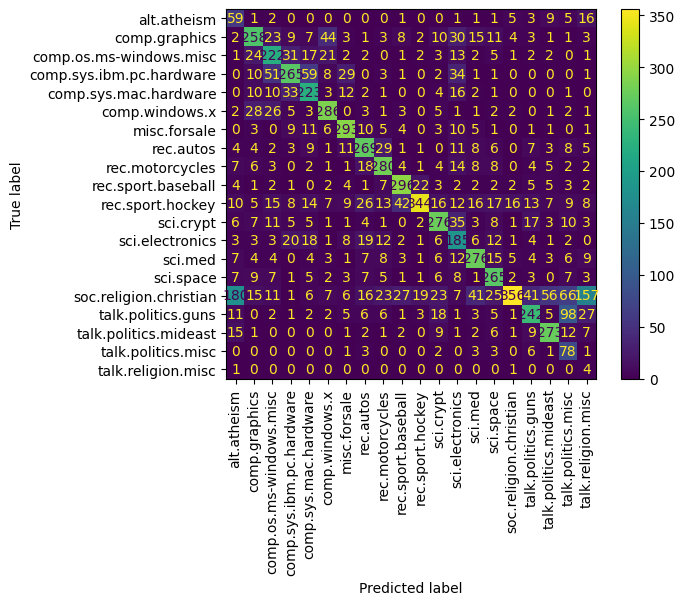

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB()),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.12      0.13      0.12       319
           comp.graphics       0.32      0.14      0.20       389
 comp.os.ms-windows.misc       0.20      0.06      0.10       394
comp.sys.ibm.pc.hardware       0.22      0.60      0.32       392
   comp.sys.mac.hardware       0.28      0.07      0.11       385
          comp.windows.x       0.48      0.25      0.33       395
            misc.forsale       0.30      0.61      0.40       390
               rec.autos       0.61      0.22      0.32       396
         rec.motorcycles       0.40      0.26      0.32       398
      rec.sport.baseball       0.22      0.21      0.21       397
        rec.sport.hockey       0.74      0.32      0.44       399
               sci.crypt       0.20      0.52      0.29       396
         sci.electronics       0.46      0.16      0.24       393
                 sci.med       0.72      0.49      0.58       396
         

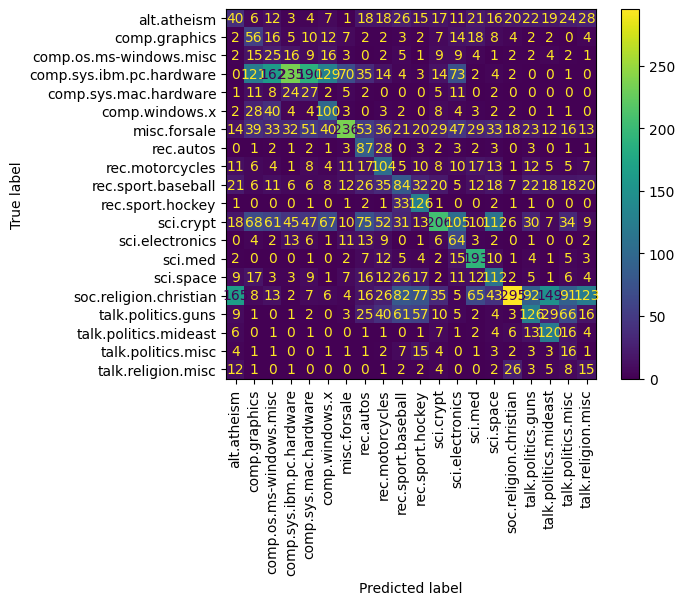

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', EmbeddingVectorizer(embedding=embeddings)),
    ('classifier', GaussianNB()),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

Iteration 1, loss = 2.98358931
Validation score: 0.124558
Iteration 2, loss = 2.92375255
Validation score: 0.278269
Iteration 3, loss = 2.82383579
Validation score: 0.295053
Iteration 4, loss = 2.67960776
Validation score: 0.368375
Iteration 5, loss = 2.52402470
Validation score: 0.384276
Iteration 6, loss = 2.38054604
Validation score: 0.370141
Iteration 7, loss = 2.25695545
Validation score: 0.406360
Iteration 8, loss = 2.15037463
Validation score: 0.444346
Iteration 9, loss = 2.05802320
Validation score: 0.454947
Iteration 10, loss = 1.97786343
Validation score: 0.497350
Iteration 11, loss = 1.90441369
Validation score: 0.507951
Iteration 12, loss = 1.83941789
Validation score: 0.541519
Iteration 13, loss = 1.77775725
Validation score: 0.536219
Iteration 14, loss = 1.72470381
Validation score: 0.552120
Iteration 15, loss = 1.67387954
Validation score: 0.561837
Iteration 16, loss = 1.62826704
Validation score: 0.561837
Iteration 17, loss = 1.58781480
Validation score: 0.580389
Iterat

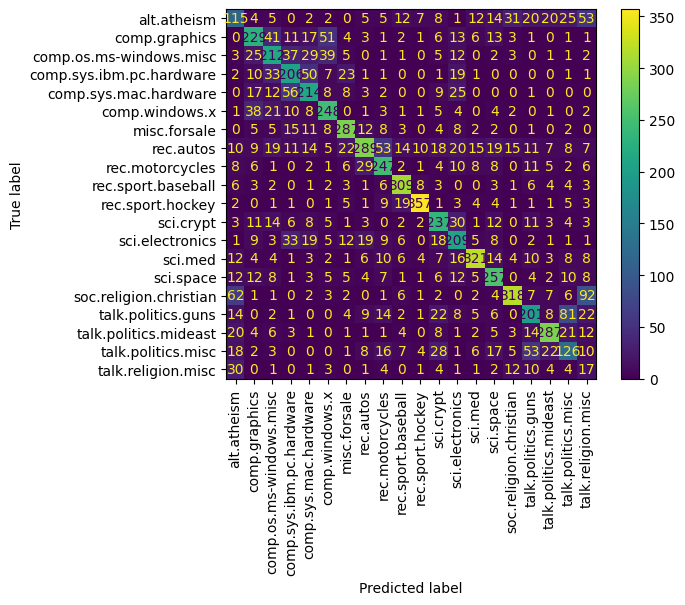

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', EmbeddingVectorizer(embedding=embeddings)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), early_stopping=True, verbose=True)),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

Iteration 1, loss = 2.88659458
Validation score: 0.539753
Iteration 2, loss = 2.38287288
Validation score: 0.672261
Iteration 3, loss = 1.74174591
Validation score: 0.717314
Iteration 4, loss = 1.24617012
Validation score: 0.734099
Iteration 5, loss = 0.93670308
Validation score: 0.750883
Iteration 6, loss = 0.73767210
Validation score: 0.758834
Iteration 7, loss = 0.59815196
Validation score: 0.763251
Iteration 8, loss = 0.49573881
Validation score: 0.765901
Iteration 9, loss = 0.41632453
Validation score: 0.766784
Iteration 10, loss = 0.35425569
Validation score: 0.767668
Iteration 11, loss = 0.30527093
Validation score: 0.767668
Iteration 12, loss = 0.26658414
Validation score: 0.766784
Iteration 13, loss = 0.23548952
Validation score: 0.767668
Iteration 14, loss = 0.21078045
Validation score: 0.765901
Iteration 15, loss = 0.19122742
Validation score: 0.763251
Iteration 16, loss = 0.17524670
Validation score: 0.764134
Iteration 17, loss = 0.16220628
Validation score: 0.765018
Iterat

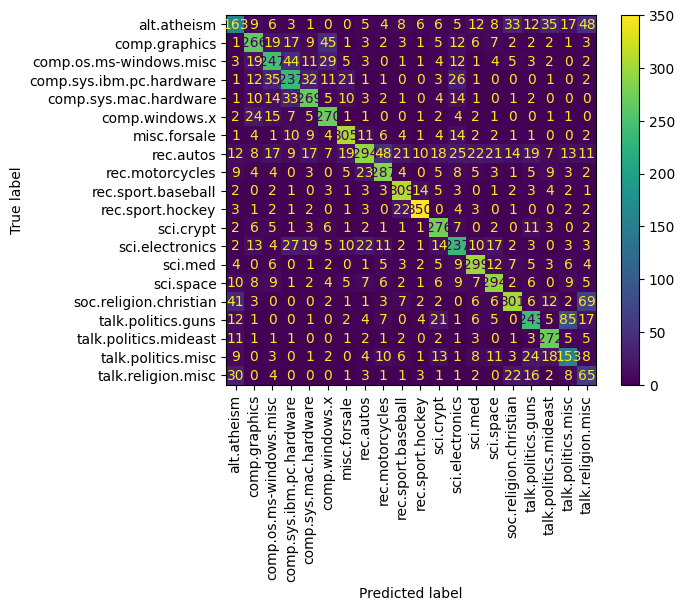

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), early_stopping=True, verbose=True)),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()

                          precision    recall  f1-score   support

             alt.atheism       0.43      0.42      0.42       319
           comp.graphics       0.56      0.64      0.60       389
 comp.os.ms-windows.misc       0.64      0.59      0.61       394
comp.sys.ibm.pc.hardware       0.62      0.59      0.60       392
   comp.sys.mac.hardware       0.69      0.62      0.65       385
          comp.windows.x       0.79      0.66      0.72       395
            misc.forsale       0.74      0.77      0.76       390
               rec.autos       0.66      0.64      0.65       396
         rec.motorcycles       0.65      0.70      0.68       398
      rec.sport.baseball       0.49      0.78      0.60       397
        rec.sport.hockey       0.85      0.83      0.84       399
               sci.crypt       0.83      0.62      0.71       396
         sci.electronics       0.48      0.57      0.52       393
                 sci.med       0.68      0.67      0.68       396
         

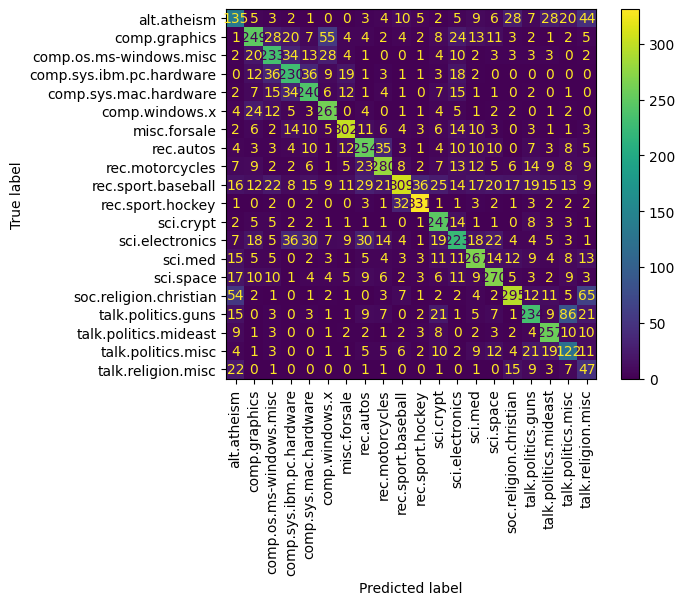

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
# Build a Naive Bayes classifier
# First vectorize the documents. Try different Naive Bayes implementations and vectorizers:
#
# Compatible combinations:
#  - BernoulliNB + CountVectorizer
#  - MultinomialNB + CountVectorizer / TfidfVectorizer
#  - GaussianNB + EmbeddingVectorizer / IdfWeightedEmbeddingVectorizer
#
# Try different parameters for the classifier

# TODO: build a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression()),
])

# train, evaluate
pipeline.fit(train.data, train.target)
test_predictions = pipeline.predict(test.data)

# report results
print(sklearn.metrics.classification_report(test.target, test_predictions, target_names=test.target_names))
disp = ConfusionMatrixDisplay.from_predictions(test_predictions, test.target, display_labels=train.target_names, xticks_rotation='vertical')
plt.show()